In [170]:
import numpy as np
import pandas as pd

import seaborn as sns
import random

#Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#sklearn modules
from scipy import stats
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error

#Time Series
import datetime
from datetime import datetime
from datetime import timedelta
from time import time

#Statsmodels
import statsmodels

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [64]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [65]:
data = pd.read_csv("yieldsamurai_data.csv", parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

/var/folders/w8/6_5lc7hj253ftrnsdhzkvbrc0000gn/T/ipykernel_75571/2897999708.py:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  data = pd.read_csv("yieldsamurai_data.csv", parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


In [66]:
data.head()

,DAPR%,TVL,DAPR
Date,,,
2021-01-05,0.07%,14.75M,0.07
2021-01-06,0.30%,12.7M,0.30
2021-01-07,0.22%,13.17M,0.22
2021-01-08,0.14%,13.36M,0.14
2021-01-09,0.18%,14.4M,0.18


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 462 entries, 2021-01-05 to 2022-04-11
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DAPR%   462 non-null    object 
 1   TVL     462 non-null    object 
 2   DAPR    462 non-null    float64
dtypes: float64(1), object(2)
memory usage: 14.4+ KB


In [68]:
df = data.asfreq(pd.infer_freq(data.index))

In [69]:
DAPR_series = df.DAPR

In [70]:
DAPR_series

Date
2021-01-05    0.07
2021-01-06    0.30
2021-01-07    0.22
2021-01-08    0.14
2021-01-09    0.18
              ... 
2022-04-07    2.54
2022-04-08    2.64
2022-04-09    2.30
2022-04-10    1.86
2022-04-11    1.83
Freq: D, Name: DAPR, Length: 462, dtype: float64

# Time Series Pre-Processing

In [80]:
# Get the Peaks and Troughs
doublediff = np.diff(np.sign(np.diff(df.DAPR)))
peak_locations = np.where(doublediff == -2)[0] + 1

doublediff2 = np.diff(np.sign(np.diff(-1*df.DAPR)))
trough_locations = np.where(doublediff2 == -2)[0] + 1

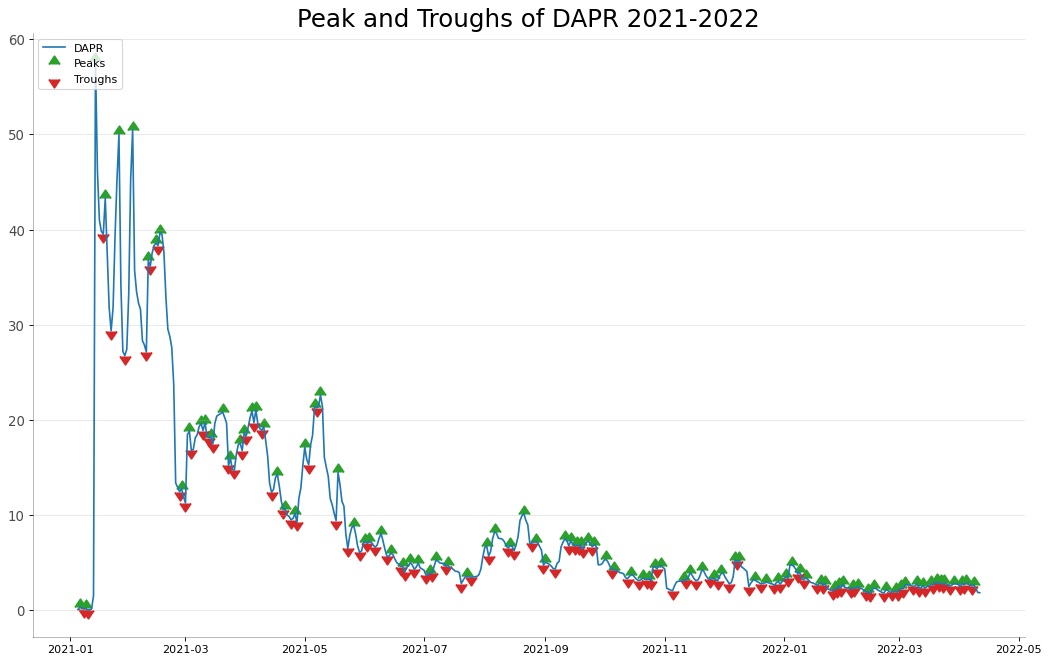

In [99]:
# Draw Plot
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(df.DAPR.index, 'DAPR', data=df, color='tab:blue', label='DAPR')
plt.scatter(df.index[peak_locations], df.DAPR[peak_locations], marker=mlp.markers.CARETUPBASE, color='tab:green', s=100, label='Peaks')
plt.scatter(df.index[trough_locations], df.DAPR[trough_locations], marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Troughs')

# Decoration
plt.title("Peak and Troughs of DAPR 2021-2022", fontsize=22)
plt.yticks(fontsize=12, alpha=.7)

# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)

plt.legend(loc='upper left')
plt.grid(axis='y', alpha=.3)
plt.show()

In [104]:
def plot_series(series):
    plt.figure(figsize=(16,10), dpi=80)
    plt.plot(DAPR_series, color='red')
    plt.ylabel('DAPR %', fontsize=16)
        


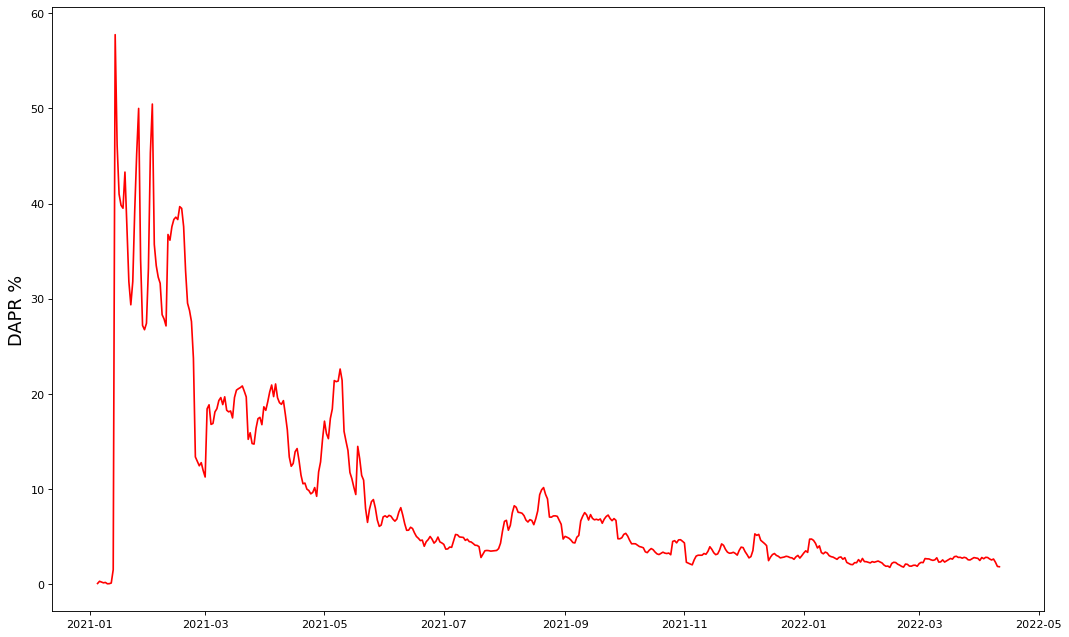

In [105]:
plot_series(DAPR_series)

## Normalize

In [106]:
avg, dev = DAPR_series.mean(), DAPR_series.std()

In [107]:
DAPR_series = (DAPR_series - avg) / dev

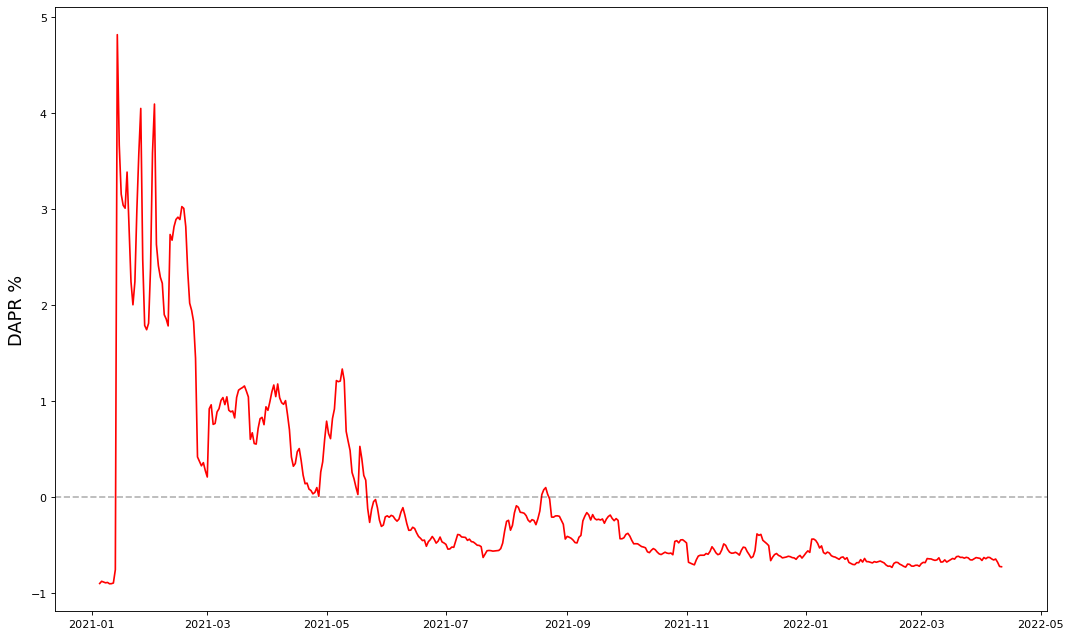

In [108]:
plot_series(DAPR_series)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

## First Difference To Remove Trend

In [111]:
DAPR_series = DAPR_series.diff().dropna()

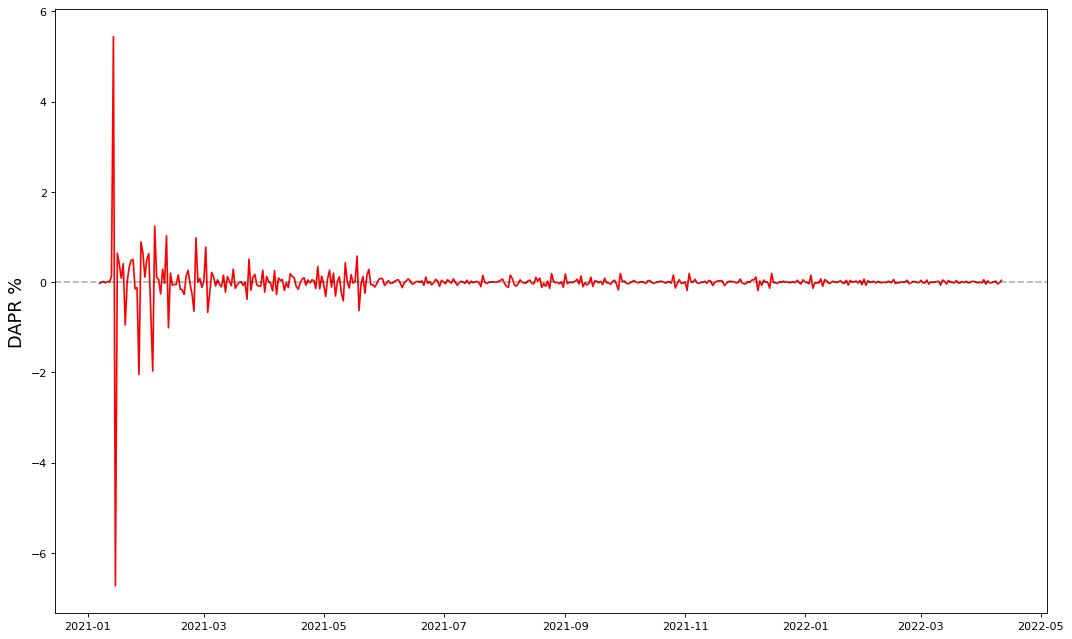

In [113]:
plot_series(DAPR_series)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

## Remove Increasing Volatility (Monthly)

In [114]:
monthly_volatility = DAPR_series.groupby(DAPR_series.index.month).std()

In [116]:
monthly_volatility

Date
1     1.227065
2     0.432922
3     0.180491
4     0.123640
5     0.241214
6     0.051170
7     0.044414
8     0.078198
9     0.078693
10    0.043737
11    0.058365
12    0.065237
Name: DAPR, dtype: float64

In [119]:
DAPR_monthly_vol = DAPR_series.index.map(lambda d: monthly_volatility.loc[d.month])

In [120]:
DAPR_monthly_vol

Float64Index([ 1.2270648566167988,  1.2270648566167988,  1.2270648566167988,
               1.2270648566167988,  1.2270648566167988,  1.2270648566167988,
               1.2270648566167988,  1.2270648566167988,  1.2270648566167988,
               1.2270648566167988,
              ...
              0.12363992889028785, 0.12363992889028785, 0.12363992889028785,
              0.12363992889028785, 0.12363992889028785, 0.12363992889028785,
              0.12363992889028785, 0.12363992889028785, 0.12363992889028785,
              0.12363992889028785],
             dtype='float64', name='Date', length=460)

In [121]:
DAPR_series = DAPR_series / DAPR_monthly_vol

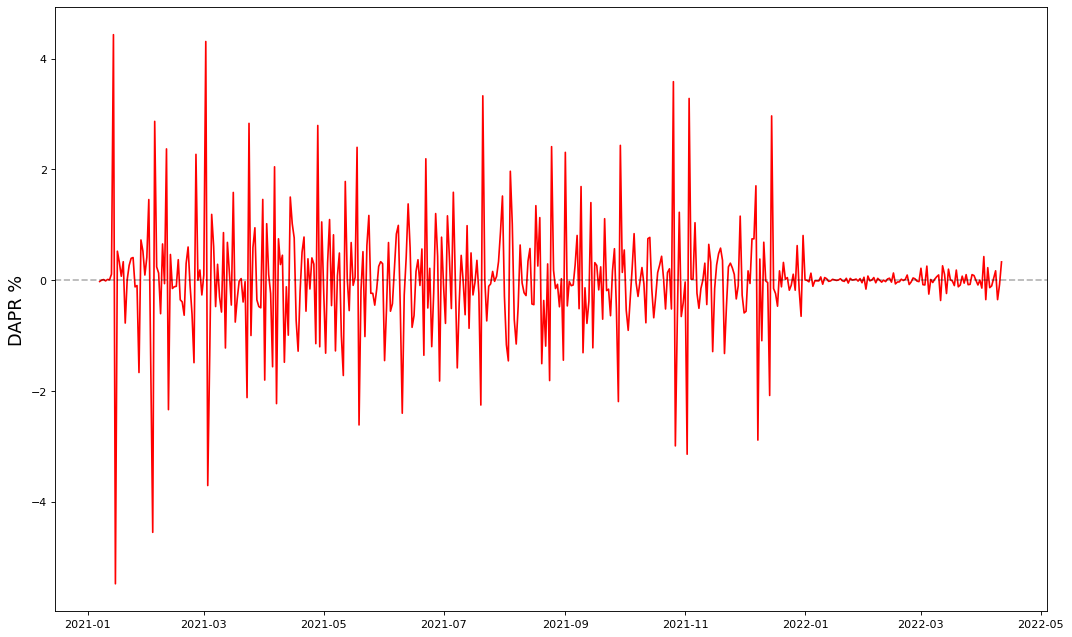

In [123]:
plot_series(DAPR_series)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

## Remove Seasonality (Weekly)

In [125]:
weekly_avgs = DAPR_series.groupby(DAPR_series.index.week).mean()

/var/folders/w8/6_5lc7hj253ftrnsdhzkvbrc0000gn/T/ipykernel_75571/3611673579.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  weekly_avgs = DAPR_series.groupby(DAPR_series.index.week).mean()


In [126]:
weekly_avgs

Date
1    -0.002791
2    -0.007503
3     0.047324
4    -0.008426
5    -0.152196
6     0.059379
7    -0.018811
8     0.000981
9     0.048258
10   -0.001177
11   -0.031781
12    0.058853
13   -0.037673
14   -0.143191
15    0.060140
16    0.162665
17    0.038816
18    0.150315
19   -0.126241
20   -0.033469
21    0.093947
22   -0.253887
23    0.060893
24    0.011072
25    0.044286
26    0.010284
27   -0.073345
28    0.003189
29   -0.009567
30    0.376092
31   -0.282548
32    0.079693
33   -0.112295
34    0.050714
35    0.029321
36    0.003600
37    0.062993
38    0.019798
39   -0.149330
40    0.077719
41   -0.064766
42    0.097149
43   -0.068004
44    0.133467
45    0.024267
46   -0.155307
47   -0.007280
48    0.082767
49   -0.069473
50    0.019539
51    0.013026
52    0.060558
dtype: float64

In [127]:
DAPR_weekly_avg = DAPR_series.index.map(lambda d: weekly_avgs.loc[d.week])

/var/folders/w8/6_5lc7hj253ftrnsdhzkvbrc0000gn/T/ipykernel_75571/4163458114.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  DAPR_weekly_avg = DAPR_series.index.map(lambda d: weekly_avgs.loc[d.week])


In [128]:
DAPR_weekly_avg

Float64Index([-0.0027911672852576268, -0.0027911672852576268,
              -0.0027911672852576268, -0.0027911672852576268,
               -0.007502573717891686,  -0.007502573717891686,
               -0.007502573717891686,  -0.007502573717891686,
               -0.007502573717891686,  -0.007502573717891686,
              ...
                 -0.0376726701844868,    -0.0376726701844868,
                -0.14319099243122527,   -0.14319099243122527,
                -0.14319099243122527,   -0.14319099243122527,
                -0.14319099243122527,   -0.14319099243122527,
                -0.14319099243122527,    0.06014021682111472],
             dtype='float64', name='Date', length=460)

In [129]:
DAPR_series = DAPR_series - DAPR_weekly_avg

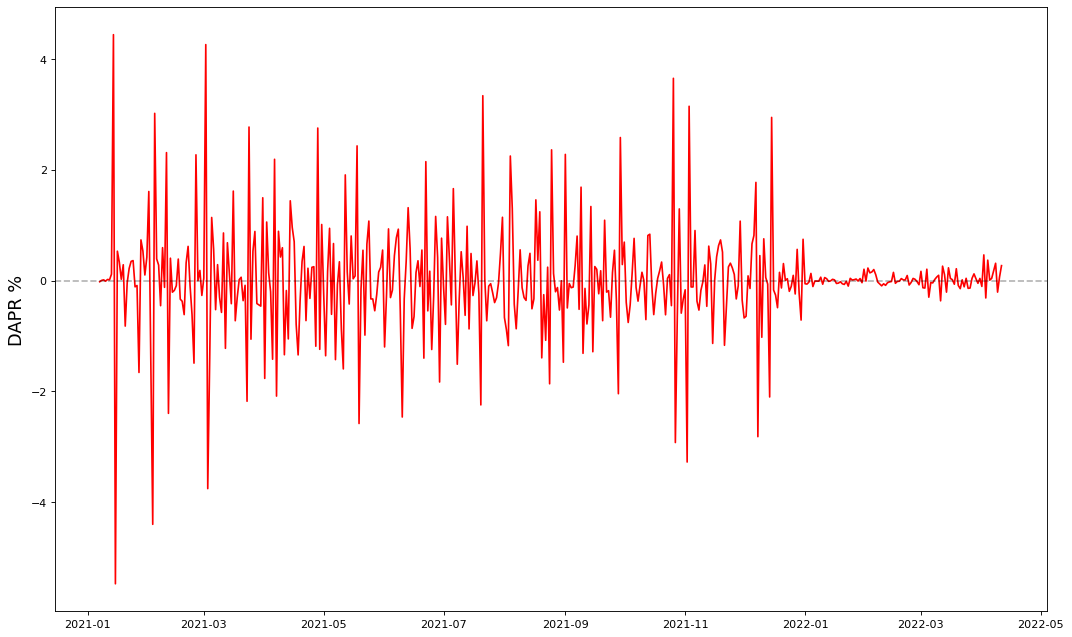

In [130]:
plot_series(DAPR_series)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

## Checking Stationarity (ADF Test)

In [175]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [176]:
#check stationarity
perform_adf_test(DAPR_series)

ADF Statistic: -10.143732
p-value: 0.000000


# ARIMA Modeling

## ACF Plot

<BarContainer object of 20 artists>

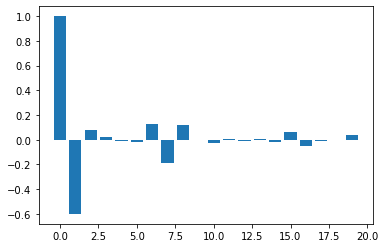

In [136]:
first_diff = DAPR_series.diff()[1:]
acf_vals = acf(first_diff)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

## PACF

<BarContainer object of 15 artists>

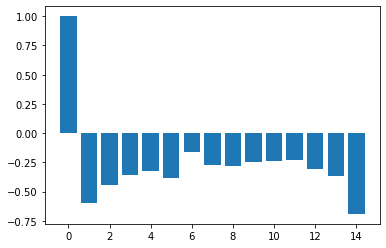

In [137]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

## Training/Test Sets

In [138]:
train_end = datetime(2021,11,1)
test_end = datetime(2022,5,1)

train_data = DAPR_series[:train_end]
test_data = DAPR_series[train_end + timedelta(days=1):test_end]

## Fit ARIMA Model

In [139]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [141]:
#fit the model
start = time()
model_fit = model.fit(disp=0)
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.21169114112854004


In [142]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  299
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -611.223
Date:                              Thu, 14 Apr 2022   AIC                           1228.446
Time:                                      12:49:29   BIC                           1239.537
Sample:                                  01-07-2021   HQIC                          1232.886
                                       - 11-01-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0897     37.147     -0.002      0.998     -72.897      72.718
ma.S.L12       0.08

In [143]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

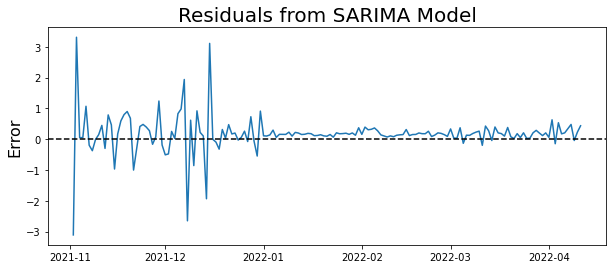

In [144]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

### Evaluation 

## Fit ARMA Model

In [154]:
#create the model
model = ARIMA(train_data, order=(0,0,2))

In [158]:
#fit the model
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.40837574005126953


In [159]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  299
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -390.581
Date:                Thu, 14 Apr 2022   AIC                            789.162
Time:                        16:48:17   BIC                            803.964
Sample:                    01-07-2021   HQIC                           795.086
                         - 11-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.003     -1.089      0.276      -0.010       0.003
ma.L1         -0.7588      0.053    -14.373      0.000      -0.862      -0.655
ma.L2         -0.1861      0.053     -3.500      0.0

In [163]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

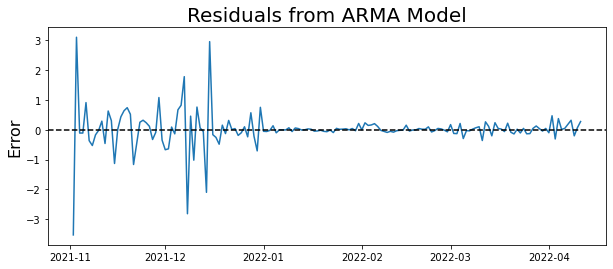

In [165]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from ARMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

## Model Selection

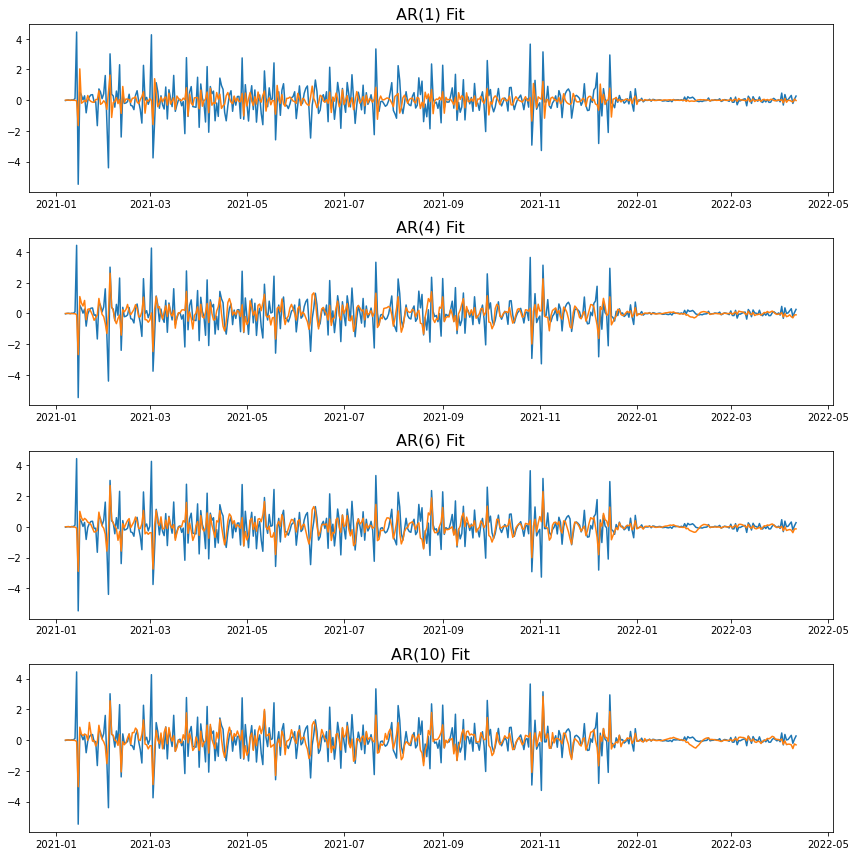

In [178]:
plt.figure(figsize=(12,12))

ar_orders = [1, 4, 6, 10]
fitted_model_dict = {}

for idx, ar_order in enumerate(ar_orders):
    
    #create AR(p) model
    ar_model = ARIMA(DAPR_series, order=(ar_order,0,0))
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
    plt.subplot(4,1,idx+1)
    plt.plot(DAPR_series)
    plt.plot(ar_model_fit.fittedvalues)
    plt.title('AR(%s) Fit'%ar_order, fontsize=16)

plt.tight_layout()

## AIC and BIC Comparison

In [179]:
#AIC comparison
for ar_order in ar_orders:
    print('AIC for AR(%s): %s'%(ar_order, fitted_model_dict[ar_order].aic))

AIC for AR(1): 1227.0224337501504
AIC for AR(4): 1148.8119456895315
AIC for AR(6): 1135.8865195507383
AIC for AR(10): 1116.2022741894211


In [180]:
#BIC comparison
for ar_order in ar_orders:
    print('BIC for AR(%s): %s'%(ar_order, fitted_model_dict[ar_order].bic))

BIC for AR(1): 1239.4161132185998
BIC for AR(4): 1173.5993046264305
BIC for AR(6): 1168.9363314666034
BIC for AR(10): 1165.7769920632188


## Rolling Origin

In [ ]:
rolling_predictions = test.data.copy()
for train_end in test_data.index:
    train_data = DAPR_series[:train_end-timedelta(days=1)]
    model = ARIMA(train_data, order = my_order, seasonal_order = my_seasonal_data)
    model_fit = model.fit()
    
    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

In [ ]:
rolling_residuals = test_data - rolling_predictions

In [ ]:
plt.figure(figsize = (10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle = '--', color = 'k')
plt.title('Rolling Forecast Residuals from SARIMAX Model', fontsize = 20)
plt.ylabel('Error', fontsize = 14)

In [ ]:
plt.figure(figsize = (10,4))

plt.plot(DAPR_series)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize = 16)

plt.title('DAPR', fontsize = 20)
plt.ylabel('Production', fontsize = 16)
for year in range(start_date.year, end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color = 'k', linestyle = '--', alpha = 0.2)